In [1]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
%matplotlib inline

import time

import datetime

In [2]:
data_swissre = pd.read_csv('./data/final_data.csv', parse_dates=['date']).set_index('date')

/Users/francescoposa/opt/anaconda3/envs/personal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
names_to_load = ['Afghanistan',
                 'Albania',
                 'Algeria',
                 'Andorra',
                 'Angola',
                 'Argentina',
                 'Australia',
                 'Austria',
                 'Azerbaijan',
                 'Bahamas',
                 'Bahrain',
                 'Bangladesh',
                 'Barbados',
                 'Belarus',
                 'Belgium',
                 'Belize',
                 'Bolivia',
                 'Brazil',
                 'Bulgaria',
                 'Canada',
                 'Chile',
                 'China',
                 'Colombia',
                 'Costa Rica',
                 'Croatia',
                 'Cyprus',
                 'Czech Republic',
                 'Ivory Coast',
                 'Denmark',
                 'Dominican Republic',
                 'Ecuador',
                 'Egypt',
                 'El Salvador',
                 'Estonia',
                 'Finland',
                 'France',
                 'Germany',
                 'Ghana',
                 'Greece',
                 'Guatemala',
                 'Guinea',
                 'Honduras',
                 'Hungary',
                 'Iceland',
                 'Indonesia',
                 'Iran',
                 'Ireland',
                 'Israel',
                 'Italy',
                 'Jamaica',
                 'Japan',
                 'Jordan',
                 'Kazakhstan',
                 'Kenya',
                 'South Korea',
                 'Kuwait',
                 'Latvia',
                 'Lebanon',
                 'Lithuania',
                 'Luxembourg',
                 'Malawi',
                 'Malaysia',
                 'Malta',
                 'Mexico',
                 'Moldova',
                 'Monaco',
                 'Mongolia',
                 'Morocco',
                 'Mozambique',
                 'Myanmar',
                 'Nepal',
                 'Netherlands',
                 'New Zealand',
                 'Nigeria',
                 'Norway',
                 'Oman',
                 'Pakistan',
                 'Panama',
                 'Paraguay',
                 'Peru',
                 'Philippines',
                 'Poland',
                 'Portugal',
                 'Qatar',
                 'Romania',
                 'Rwanda',
                 'San Marino',
                 'Saudi Arabia',
                 'Senegal',
                 'Serbia',
                 'Seychelles',
                 'Sierra Leone',
                 'Singapore',
                 'Slovakia',
                 'Slovenia',
                 'South Africa',
                 'Spain',
                 'Sri Lanka',
                 'Suriname',
                 'Sweden',
                 'Switzerland',
                 'Thailand',
                 'Togo',
                 'Trinidad and Tobago',
                 'Tunisia',
                 'Turkey',
                 'Uganda',
                 'Ukraine',
                 'United Arab Emirates',
                 'United Kingdom',
                 'USA',
                 'Uruguay',
                 'Venezuela',
                 'Viet Nam',
                 'Zimbabwe']

selected_countries = [data_swissre[data_swissre['name'] == name]['iso_code'].unique()[0] for name in names_to_load]

# Selecting columns for the first model

In [4]:
with open('config/r_estim_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
columns_to_use = swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['vaccines'] +\
            swissre_features['economic'] +\
            swissre_features['policies'] +\
            swissre_features['outcome'] +\
            ['new_cases', 'deaths', 'recovered']
    
outcome = 'epiforecasts_effective_reproduction_number_median' # r_estim epiforecasts_effective_reproduction_number_median

In [6]:
df = data_swissre[columns_to_use].copy()

### Vaccines: shifting them 10 days below

In [7]:
# for country in df.iso_code.unique():
#    temp = df[df['iso_code'] == country][['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations', 'vaccination_policy']]
#    temp = temp.shift(periods=14, fill_value=0)
#    df.loc[df['iso_code'] == country,['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations', 'vaccination_policy']] = temp

### Normal workflow

In [8]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index() #

In [9]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [10]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 168


In [11]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])

In [12]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])
df['shifted_r_estim'] = df[outcome]

In [13]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 162


In [14]:
df.loc[df['iso_code'] == 'CYP', 'population_percentage_over_60'] = 19.79

In [15]:
df.to_csv('final_data_with_excluded_countries_to_avoid_code_in_backend.csv')

# Training the first model

In [16]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot

In [ ]:
start_time = time.time()

for final_iso_code in selected_countries:
    print(f"Model for {final_iso_code}")

    # Final training colums
    train_cols= swissre_features['demography'] +\
                swissre_features['sanitary'] +\
                swissre_features['weather'] +\
                swissre_features['economic'] +\
                swissre_features['policies'] 

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]

    context = Context()

    pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, 7, context) #shifted_r_estim
    pipeline.fit_pipeline(save_model=True)

delta = time.time() - start_time
print(f"--- {delta} seconds ---")

computation_cost = delta * (40 / 3.6e6) * 447 

print(f"--- {computation_cost} gCO2eq ---")

In [17]:
final_iso_code = 'ZAF'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic'] +\
            swissre_features['policies'] 

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]

context = Context()

pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, 7, context) #shifted_r_estim
pipeline.fit_pipeline(save_model=True)

predictions = pipeline.predict()

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


(tensor([[-0.1813, -0.1817, -0.1821,  ..., -1.2568, -1.2391, -1.2194],
        [-0.1813, -0.1817, -0.1821,  ..., -1.2568, -1.2391, -1.2194],
        [-0.1813, -0.1817, -0.1821,  ..., -1.2568, -1.2391, -1.2194],
        ...,
        [-0.3279, -0.3273, -0.3267,  ..., -0.4891, -0.4660, -0.4431],
        [-0.3279, -0.3273, -0.3267,  ..., -0.4891, -0.4660, -0.4431],
        [-0.3279, -0.3273, -0.3267,  ..., -0.4891, -0.4660, -0.4431]],
       dtype=torch.float64), tensor([[[ 0.3718,  0.3425,  0.5951,  ...,  0.4855,  0.3076,  0.3396],
         [ 0.5488,  0.5362,  0.5951,  ...,  0.9966, -0.5659,  0.3396],
         [ 0.7259,  0.7299,  0.5951,  ...,  1.5076,  0.3076,  0.3396],
         ...,
         [ 0.7259,  0.7299,  0.5951,  ...,  0.9966,  0.3076,  0.3396],
         [ 0.5488,  0.5362,  0.5951,  ...,  0.9966,  0.8899,  0.3396],
         [ 0.6374,  0.6331,  0.5951,  ...,  0.9966,  0.0164,  0.3396]],

        [[ 0.5488,  0.5362,  0.5951,  ...,  0.9966, -0.5659,  0.3396],
         [ 0.7259,  0.7


  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


.............................................................................................................................................................................................................................................................................................................

In [19]:
import torch

In [20]:
p1 = torch.from_numpy(np.random.rand(1,37)*0.05)

In [21]:
p1

tensor([[0.0187, 0.0475, 0.0366, 0.0299, 0.0078, 0.0078, 0.0029, 0.0433, 0.0301,
         0.0354, 0.0010, 0.0485, 0.0416, 0.0106, 0.0091, 0.0092, 0.0152, 0.0262,
         0.0216, 0.0146, 0.0306, 0.0070, 0.0146, 0.0183, 0.0228, 0.0393, 0.0100,
         0.0257, 0.0296, 0.0023, 0.0304, 0.0085, 0.0033, 0.0474, 0.0483, 0.0404,
         0.0152]], dtype=torch.float64)

In [22]:
p2 = torch.from_numpy(np.random.rand(1,7,21)*0.05)

In [23]:
p2

tensor([[[0.0049, 0.0342, 0.0220, 0.0061, 0.0248, 0.0017, 0.0455, 0.0129,
          0.0331, 0.0156, 0.0260, 0.0273, 0.0092, 0.0485, 0.0388, 0.0470,
          0.0447, 0.0299, 0.0461, 0.0044, 0.0098],
         [0.0023, 0.0163, 0.0194, 0.0136, 0.0414, 0.0178, 0.0140, 0.0271,
          0.0070, 0.0401, 0.0037, 0.0493, 0.0386, 0.0099, 0.0003, 0.0408,
          0.0353, 0.0365, 0.0386, 0.0037, 0.0179],
         [0.0058, 0.0432, 0.0312, 0.0165, 0.0032, 0.0155, 0.0163, 0.0365,
          0.0319, 0.0444, 0.0236, 0.0060, 0.0357, 0.0380, 0.0281, 0.0385,
          0.0247, 0.0261, 0.0214, 0.0013, 0.0054],
         [0.0016, 0.0318, 0.0157, 0.0254, 0.0454, 0.0125, 0.0205, 0.0378,
          0.0114, 0.0038, 0.0145, 0.0081, 0.0465, 0.0404, 0.0317, 0.0436,
          0.0402, 0.0093, 0.0446, 0.0270, 0.0404],
         [0.0448, 0.0159, 0.0055, 0.0114, 0.0214, 0.0409, 0.0430, 0.0003,
          0.0255, 0.0209, 0.0111, 0.0060, 0.0169, 0.0471, 0.0162, 0.0259,
          0.0352, 0.0182, 0.0486, 0.0481, 0.0126],
     

In [24]:
pipeline.get_model().eval()(*(p1, p2)).detach()

tensor([[1.3641]], dtype=torch.float64)

In [25]:
for p in pipeline.get_model().parameters():
    print(p)

Parameter containing:
tensor([[ 0.9961,  1.1695,  1.1349,  ...,  0.9669,  0.3699,  0.1939],
        [ 0.0560,  0.2770,  0.2446,  ...,  0.4682,  0.5880, -0.8959],
        [ 0.5865,  0.9948, -0.2411,  ..., -0.2222, -0.5905,  0.1675],
        ...,
        [ 0.0906,  0.3339,  0.0195,  ...,  0.3511, -0.1507, -0.2043],
        [ 0.3820,  0.3384, -0.1422,  ..., -0.1768, -0.9679,  0.4012],
        [ 0.1250,  0.5060,  0.4799,  ...,  0.3924, -0.1282, -0.6876]],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-1.6906,  0.2957,  0.4493,  ...,  1.6375, -0.6019,  0.6202],
        [ 1.8185,  1.6116,  2.4751,  ...,  2.5234, -0.3723,  0.6310],
        [ 0.1559,  1.4133, -2.6777,  ..., -0.4263,  1.1291,  0.2809],
        ...,
        [ 1.9384,  1.8348,  0.6957,  ...,  1.0423, -1.6329, -1.8811],
        [ 0.9364, -0.2426,  1.5705,  ...,  0.6681,  0.7166, -0.4469],
        [ 0.0304,  0.1292, -1.6086,  ...,  0.0975, -0.3769, -0.2045]],
       dtype=torch.float64, requires_gra

In [26]:
predictions

array([       nan,        nan,        nan,        nan,        nan,
              nan, 1.43055527, 1.42671157, 1.40918864, 1.39636701,
       1.40544366, 1.40102138, 1.40276874, 1.38920059, 1.30786487,
       1.32422469, 1.32636211, 1.30474511, 1.31785017, 1.25127809,
       1.17584439, 1.25054652, 1.30497107, 1.33642171, 1.37483587,
       1.37441715, 1.35657924, 1.2858416 , 1.29307237, 1.26438244,
       1.23668391, 1.19606888, 1.23544458, 1.2595589 , 1.27624344,
       1.28440531, 1.28129192, 1.28412644, 1.27799793, 1.28742814,
       1.27316162, 1.26633338, 1.24650517, 1.26995078, 1.28346215,
       1.28288453, 1.27804039, 1.27602521, 1.26584393, 1.28389273,
       1.29340318, 1.28980539, 1.2685314 , 1.26379515, 1.25318403,
       1.26034765, 1.2579834 , 1.22474341, 1.23026911, 1.21234516,
       1.18248114, 1.1745168 , 1.18154509, 1.22090564, 1.27308434,
       1.33564452, 1.34241652, 1.32894939, 1.30155953, 1.28523333,
       1.26761664, 1.25979438, 1.2723119 , 1.25976026, 1.24785

In [27]:
df[df['iso_code'] == 'ZAF']['shifted_r_estim']

date
2020-04-01    1.100000
2020-04-02    1.100000
2020-04-03    1.200000
2020-04-04    1.200000
2020-04-05    1.200000
                ...   
2021-05-27    1.108691
2021-05-28    1.118983
2021-05-29    1.131438
2021-05-30    1.144755
2021-05-31    1.160234
Name: shifted_r_estim, Length: 426, dtype: float64

The mean average error was 0.19639375000631687


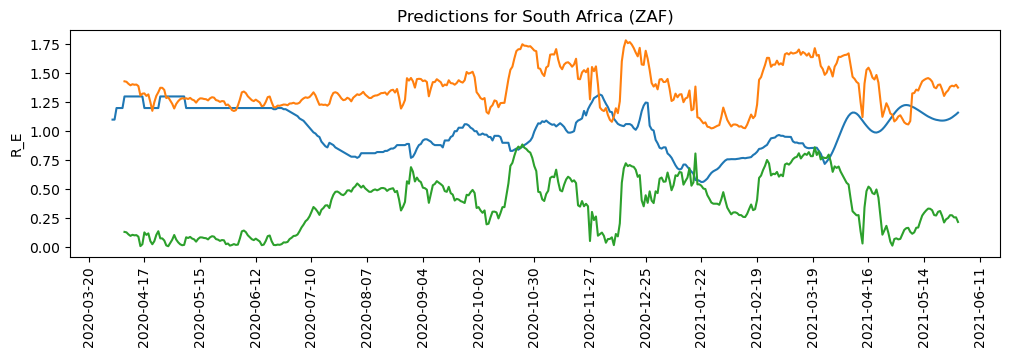

In [28]:
plot = Plot(df, 'shifted_r_estim', final_iso_code, 'South Africa', save_path='./plots/') 
plot.plot_results(predictions, show = True)

In [17]:
test_indices = df['iso_code'] == final_iso_code
index = df[test_indices].index
ground = df.loc[test_indices]['shifted_r_estim']
mse = np.square(ground - predictions)

In [18]:
import simplejson as json

y = [
    {
        'label': 'Ground',
        'data': [round(value, 4) for value in ground.values.tolist()]
    },
    {
        'label': 'Predictions',
        'data': [round(value, 4) for value in predictions.tolist()]
    },
    {
        'label': 'Error',
        'data': [round(value, 4) for value in mse.values.tolist()]
    }
]

x = index.strftime('%Y-%m-%d').values.tolist()

plot = {
    'x' : x,
    'y' : y
}

output = json.dumps(plot, ignore_nan=True)

with open(f'{final_iso_code}.json', 'w') as f:
    f.write(output)

In [19]:
selected_names = ['Switzerland'] # 'Morocco', 'Peru'
selected_countries = ['CHE'] # 'MAR', 'PER'

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 4.3 K 
1 | linear_1 | Linear | 2.4 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

...............................

TypeError: 'AxesSubplot' object is not subscriptable

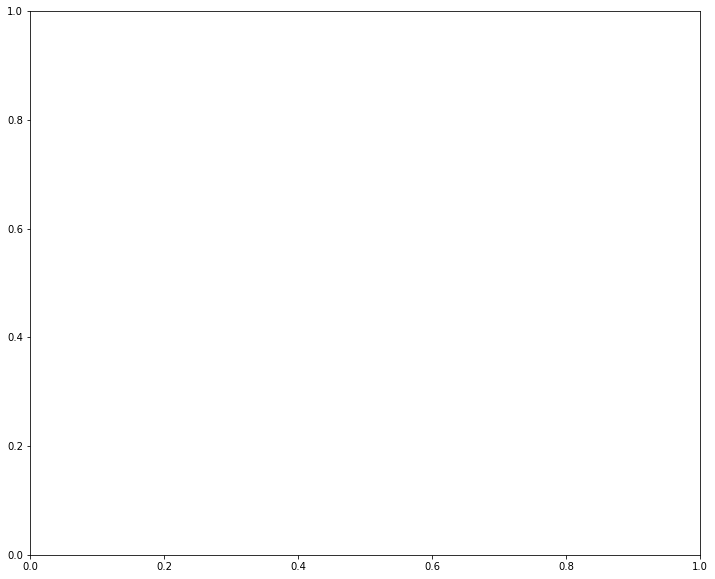

In [15]:
fig, axis = plt.subplots(len(selected_countries), 1, sharex=True, sharey=True, figsize = (12, 10))

for index in range(len(selected_countries)):
    final_iso_code = selected_countries[index]
    
    # Final training colums
    train_cols= swissre_features['demography'] +\
                swissre_features['sanitary'] +\
                swissre_features['weather'] +\
                swissre_features['vaccines'] +\
                swissre_features['economic'] +\
                swissre_features['policies'] 

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
    
    context = Context()
    
    pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, 7, context) #shifted_r_estim
    pipeline.fit_pipeline(save_model=False)
    
    predictions = pipeline.predict()
    plot = Plot(df, 'shifted_r_estim', final_iso_code, selected_names[index], save_path='./plots/')
    
    plot.plot_results(predictions, show = False, axis = axis[index], show_x_label=(index==len(selected_countries)-1), show_legend=(index==0))

plt.show()

In [17]:
fig.savefig('restim_plots.pdf', bbox_inches='tight')

invalid value encountered in true_divide
invalid value encountered in true_divide
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


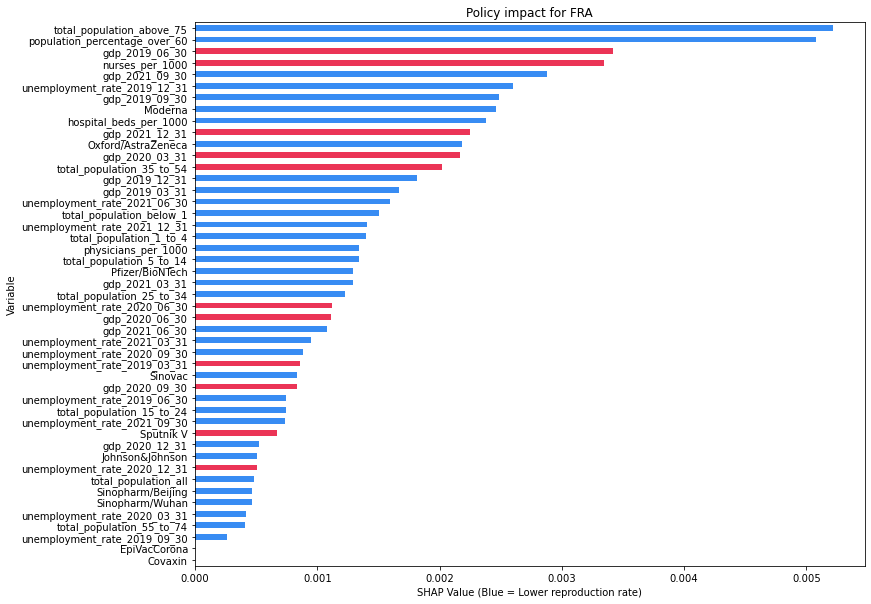

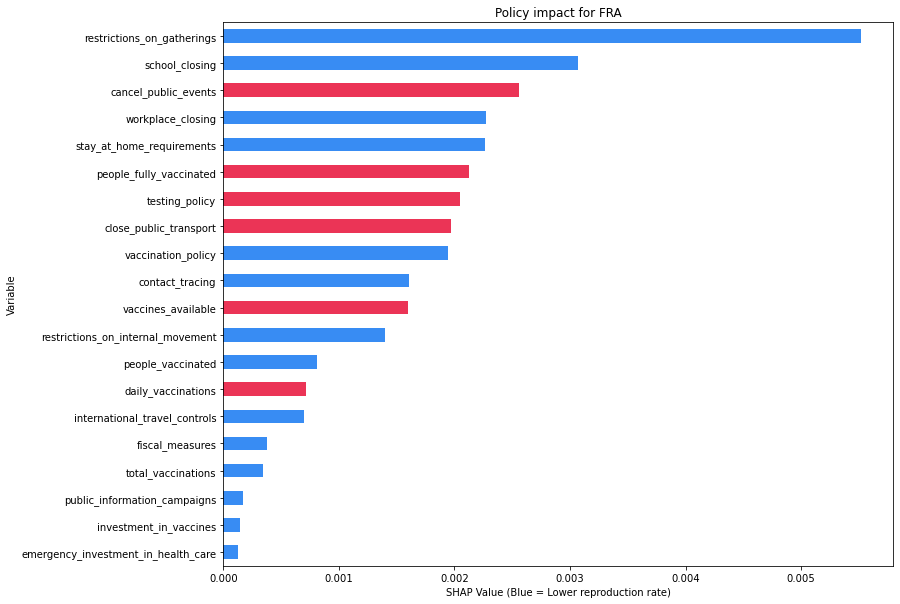

In [120]:
# Plotting shap
train, val = pipeline.get_data()

const_cols, var_cols = pipeline.get_cols()
plot.plot_shap(pipeline.get_model(), const_cols, var_cols, train, val, plot_bars=True, cols_to_drop = swissre_features['weather'])